# Segmentación de clientes

## Configuración inicial y librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el preprocesamiento
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(transform_output = "pandas")

# Para el clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Para visualización de métodos de determinación de K
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Para la carga de datos
from os import path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Obtención de datos

In [2]:
base_path = '/content/drive/MyDrive/data/TFM/clean_datasets'

df_sales = pd.read_csv(path.join(base_path, 'sales_clean.csv'), index_col=0)
print(f'df_sales: {df_sales.shape[0]} filas cargadas')

df_customer_commercial_activity = pd.read_csv(path.join(base_path, 'customer_commercial_activity_clean.csv'), index_col=0)
print(f'df_customer_commercial_activity: {df_customer_commercial_activity.shape[0]} filas cargadas')

df_customer_products = pd.read_csv(path.join(base_path, 'customer_products_clean.csv'), index_col=0)
print(f'df_customer_products: {df_customer_products.shape[0]} filas cargadas')

df_customer_sociodemographics = pd.read_csv(path.join(base_path, 'customer_sociodemographics_clean.csv'), index_col=0)
print(f'df_customer_sociodemographics: {df_customer_sociodemographics.shape[0]} filas cargadas')

df_sales: 240773 filas cargadas
df_customer_commercial_activity: 5962924 filas cargadas
df_customer_products: 5962924 filas cargadas
df_customer_sociodemographics: 5959602 filas cargadas


## 2. Selección y Preprocesamiento de Características para Clustering

### 2.1. df_sales: de aqui sacamos las siguientes variables


*   n_orders
*   total_margin



In [3]:
df_sales.head(3)

,pk_sale,cid,month_sale,product_ID,net_margin
0,6666,33620,2018-05-01,2335,952.9
1,6667,35063,2018-06-01,2335,1625.2
2,6668,37299,2018-02-01,2335,1279.7


In [4]:
# Numero de pedidos realizados
orders = df_sales.groupby('cid').agg(
    n_orders=('pk_sale', 'count'),
    margin_gained=('net_margin', 'sum')
)
orders['margin_gained'] = orders['margin_gained'].fillna(0)

In [5]:
orders.head(3)

,n_orders,margin_gained
cid,,
15891,1,66.4
16203,1,96.7
16502,2,132.9


### 2.2. df_customer_products: de aqui sacamos las siguientes variables


*   total_items

In [6]:
df_customer_products.head(3)

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
# Habrá que reducir la dimensionalidad de este dataframe al numero de clientes unicos
# Nos quedamos con el ultimo dato de cada cliente
print(f'{df_customer_products.shape[0]} filas')
print(f'{df_customer_products.pk_cid.nunique()} clientes unicos')
df_customer_products_latest = df_customer_products.sort_values(by='pk_partition').drop_duplicates(subset=['pk_cid'], keep='last').drop('pk_partition', axis=1)

# total_items
items_list = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount']
df_customer_products_latest['total_items'] = df_customer_products_latest[items_list].sum(axis=1)
df_customer_products_latest.drop(columns=items_list, inplace=True)


5962924 filas
456373 clientes unicos


In [8]:
df_customer_products_latest.head(3)

,pk_cid,total_items
4492909,1298102,0
4492736,1297423,0
4494512,1299907,0


### 2.3. df_customer_sociodemographics: de aqui sacamos las siguientes variables


*   months_in_company
*   region_code
*   gender
*   age
*   salary



In [9]:
df_customer_sociodemographics.head(3)

,pk_cid,pk_partition,region_code,gender,age,salary
0,1375586,2018-01-01,29.0,H,35,87218.10
1,1050611,2018-01-01,13.0,V,23,35548.74
2,1050612,2018-01-01,13.0,V,23,122179.11


In [10]:
# Habrá que reducir la dimensionalidad de este dataframe al numero de clientes unicos
print(f'{df_customer_sociodemographics.shape[0]} filas')
print(f'{df_customer_sociodemographics.pk_cid.nunique()} clientes unicos')

aggregated_sociodemographics = (
    df_customer_sociodemographics
    .sort_values(by='pk_partition')
    .groupby('pk_cid').agg(
        months_in_company = ('pk_partition', 'count'),  # Cuantos meses ha estado en la compañía
        region_code = ('region_code', 'last'),          # Ultima region de residencia
        gender = ('gender', 'last'),                    # Último dato de género
        age = ('age', 'last'),                          # Última edad registrada
        salary = ('salary', 'mean')                     # Media de los salarios que haya tenido
    )
    .reset_index()
)
aggregated_sociodemographics['salary'] = aggregated_sociodemographics['salary'].round(2)
aggregated_sociodemographics['region_code'] = aggregated_sociodemographics['region_code'].astype(int)

# Region costera
# provincias_costeras = [3,4,7,8,11,12,15,17,21,27,29,30,33,35,36,38,39,43,46,48,20]
# aggregated_sociodemographics['coastal_region'] = np.where(aggregated_sociodemographics.region_code.isin(provincias_costeras), 1, 0)

5959602 filas
456172 clientes unicos


In [11]:
aggregated_sociodemographics.head(3)

,pk_cid,months_in_company,region_code,gender,age,salary
0,15891,2,28,H,59,176628.78
1,16063,7,28,H,62,163192.43
2,16203,6,8,V,70,152281.83


### 2.4. df_customer_comercial_activity: de aqui sacamos las siguientes variables:


*   channel_encoded (OneHotEncoding)
*   active_customer



In [12]:
df_customer_commercial_activity.head(3)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,new_customer
0,1375586,2018-01-01,2018-01-01,KHL,1.0,02 - PARTICULARES,0
1,1050611,2018-01-01,2015-08-01,KHE,0.0,03 - UNIVERSITARIO,0
2,1050612,2018-01-01,2015-08-01,KHE,0.0,03 - UNIVERSITARIO,0


In [13]:
# Habrá que reducir la dimensionalidad de este dataframe al numero de clientes unicos
print(f'{df_customer_commercial_activity.shape[0]} filas')
print(f'{df_customer_commercial_activity.pk_cid.nunique()} clientes unicos')

aggregated_commercial = (
    df_customer_commercial_activity
    .sort_values(by='pk_partition')
    .groupby('pk_cid').agg(
        last_channel = ('entry_channel', 'last'),
        active_customer = ('active_customer', 'last'),
    )
    .reset_index()
)

5962924 filas
456373 clientes unicos


In [14]:
aggregated_commercial.head(3)

,pk_cid,last_channel,active_customer
0,15891,KAT,0.0
1,16063,KAT,0.0
2,16203,KAT,1.0


### Joins para el dataframe final

In [15]:
# aggregated_sociodemographics + orders

df_final = pd.merge(aggregated_sociodemographics, orders, left_on='pk_cid', right_index=True, how='left')
df_final['n_orders'] = df_final['n_orders'].fillna(0).astype(int)
df_final['margin_gained'] = df_final['margin_gained'].fillna(0).astype(float)

print(df_final.shape)
df_final.head(3)

(456172, 8)


,pk_cid,months_in_company,region_code,gender,age,salary,n_orders,margin_gained
0,15891,2,28,H,59,176628.78,1,66.4
1,16063,7,28,H,62,163192.43,0,0.0
2,16203,6,8,V,70,152281.83,1,96.7


In [16]:
# +aggregated_commercial
df_final = pd.merge(df_final, aggregated_commercial, on='pk_cid', how='left')
# df_final['active_customer'] = df_final['active_customer'].fillna(df_final['active_customer'].mode()[0])
# df_final['last_channel'] = df_final['last_channel'].fillna(df_final['last_channel'].mode()[0])

print(df_final.shape)
df_final.head(3)

(456172, 10)


,pk_cid,months_in_company,region_code,gender,age,salary,n_orders,margin_gained,last_channel,active_customer
0,15891,2,28,H,59,176628.78,1,66.4,KAT,0.0
1,16063,7,28,H,62,163192.43,0,0.0,KAT,0.0
2,16203,6,8,V,70,152281.83,1,96.7,KAT,1.0


In [17]:
# +df_customer_products_latest

df_final = pd.merge(df_final, df_customer_products_latest, on='pk_cid', how='left')

print(df_final.shape)
df_final.head(3)

(456172, 11)


,pk_cid,months_in_company,region_code,gender,age,salary,n_orders,margin_gained,last_channel,active_customer,total_items
0,15891,2,28,H,59,176628.78,1,66.4,KAT,0.0,0
1,16063,7,28,H,62,163192.43,0,0.0,KAT,0.0,0
2,16203,6,8,V,70,152281.83,1,96.7,KAT,1.0,1


In [18]:
print(f'{df_final['pk_cid'].nunique()} clientes unicos')
print(f'{df_final.isnull().sum().sum()} nulos\n')

df_final.head()

456172 clientes unicos
0 nulos



,pk_cid,months_in_company,region_code,gender,age,salary,n_orders,margin_gained,last_channel,active_customer,total_items
0,15891,2,28,H,59,176628.78,1,66.4,KAT,0.0,0
1,16063,7,28,H,62,163192.43,0,0.0,KAT,0.0,0
2,16203,6,8,V,70,152281.83,1,96.7,KAT,1.0,1
3,16502,9,28,H,58,176423.12,2,132.9,KHN,1.0,2
4,17457,17,28,H,54,102405.75,1,56.0,KAT,1.0,3


In [19]:
df_final.isna().sum()

,0
pk_cid,0
months_in_company,0
region_code,0
gender,0
age,0
salary,0
n_orders,0
margin_gained,0
last_channel,0
active_customer,0


## 3. Preparación para aplicar el algortimo K-means

In [20]:
# 456.172 'clientes unicos':    pandas
# Tratar variables catgoricas:  skicit
# Escalar los datos:            scikit
# K-means:                      scikit

In [21]:
# Clave primaria -> pk_cid
df_final.set_index('pk_cid', inplace=True)

In [22]:
# GENDER: 1 para Varon, 0 para Hembra
df_final['gender'] = np.where(df_final['gender'] == 'H', 0, 1)

In [23]:
# LAST_CHANNEL: agrupamos valores con menos de 1000 registros como 'otros'
print(f'Valores unicos antes: {df_final.last_channel.nunique()}')

value_counts = df_final['last_channel'].value_counts()
low_frequency_channels = value_counts[value_counts < 10000].index
df_final['last_channel'] = df_final['last_channel'].replace(low_frequency_channels, 'OTHERS')

print(f'Valores unicos despues: {df_final.last_channel.nunique()}')

df_final['last_channel'].value_counts()

Valores unicos antes: 67
Valores unicos despues: 8


,count
last_channel,
KHE,205477
KHQ,76110
KFC,59923
KHM,31917
KAT,26854
OTHERS,21976
KHN,17028
KHK,16887


In [24]:
# Comprobamos si hay outliers en el df_final
df_final.describe()

,months_in_company,region_code,gender,age,salary,n_orders,margin_gained,active_customer,total_items
count,456172.000000,456172.000000,456172.000000,456172.000000,4.561720e+05,456172.000000,456172.000000,456172.000000,456172.000000
mean,13.064375,25.879609,0.487553,30.565868,1.153995e+05,0.527623,320.198171,0.377476,0.962356
std,4.624676,13.532159,0.499846,12.324402,1.692811e+05,0.967948,1351.919391,0.484756,0.903885
min,1.000000,1.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,10.000000,13.000000,0.000000,22.000000,7.159025e+04,0.000000,0.000000,0.000000,0.000000
50%,17.000000,28.000000,0.000000,25.000000,9.549693e+04,0.000000,0.000000,0.000000,1.000000
75%,17.000000,36.000000,1.000000,36.000000,1.378740e+05,1.000000,64.500000,1.000000,1.000000
max,17.000000,52.000000,1.000000,105.000000,2.889440e+07,10.000000,18649.900000,1.000000,9.000000


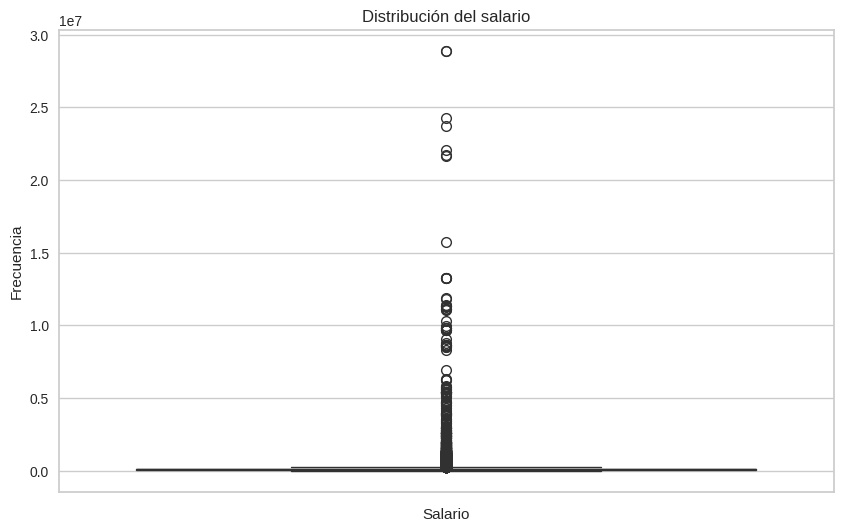

In [25]:
# Detectamos outliers en 'salary' asi que optaremos por un RobustScaler
plt.figure(figsize=(10, 6))
sns.boxplot(df_final['salary'])
plt.title('Distribución del salario')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')
plt.show()

In [26]:
df_final.head(3)

,months_in_company,region_code,gender,age,salary,n_orders,margin_gained,last_channel,active_customer,total_items
pk_cid,,,,,,,,,,
15891,2,28,0,59,176628.78,1,66.4,KAT,0.0,0
16063,7,28,0,62,163192.43,0,0.0,KAT,0.0,0
16203,6,8,1,70,152281.83,1,96.7,KAT,1.0,1


In [27]:
# Aplicar OneHotEncoding a las varibales categoricas

channel_encoded = pd.get_dummies(df_final['last_channel'], prefix='channel').astype(int)
df_final = pd.concat([df_final, channel_encoded], axis=1)
df_final.drop('last_channel', axis=1, inplace=True)

# channel_encoded = pd.get_dummies(df_final['region_code'], prefix='region')
# df_final = pd.concat([df_final, channel_encoded], axis=1)
df_final.drop('region_code', axis=1, inplace=True)

df_final.head(3)

,months_in_company,gender,age,salary,n_orders,margin_gained,active_customer,total_items,channel_KAT,channel_KFC,channel_KHE,channel_KHK,channel_KHM,channel_KHN,channel_KHQ,channel_OTHERS
pk_cid,,,,,,,,,,,,,,,,
15891,2,0,59,176628.78,1,66.4,0.0,0,1,0,0,0,0,0,0,0
16063,7,0,62,163192.43,0,0.0,0.0,0,1,0,0,0,0,0,0,0
16203,6,1,70,152281.83,1,96.7,1.0,1,1,0,0,0,0,0,0,0


In [28]:
df_final.isna().sum()

,0
months_in_company,0
gender,0
age,0
salary,0
n_orders,0
margin_gained,0
active_customer,0
total_items,0
channel_KAT,0
channel_KFC,0


## 4. Aplicación del Algoritmo K-Means

In [29]:
# imputar nulos
pipe = Pipeline(steps=[
    ('RobustScaler', RobustScaler(quantile_range = (0, 99.0))),
    ('Clustering', KMeans(n_clusters=5, random_state=123))
])
pipe

Pipeline(steps=[('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=5, random_state=123))])

In [30]:
transformed_df = pipe[:1].fit_transform(df_final)

In [31]:
df_final.isna().sum()

,0
months_in_company,0
gender,0
age,0
salary,0
n_orders,0
margin_gained,0
active_customer,0
total_items,0
channel_KAT,0
channel_KFC,0


In [32]:
sse = {}

for k in range(2, 11):

  print(f'Fitting pipe with {k} clusters')

  clustering_model = KMeans(n_clusters=k)
  clustering_model.fit(df_final)

  sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters


In [33]:
# sse

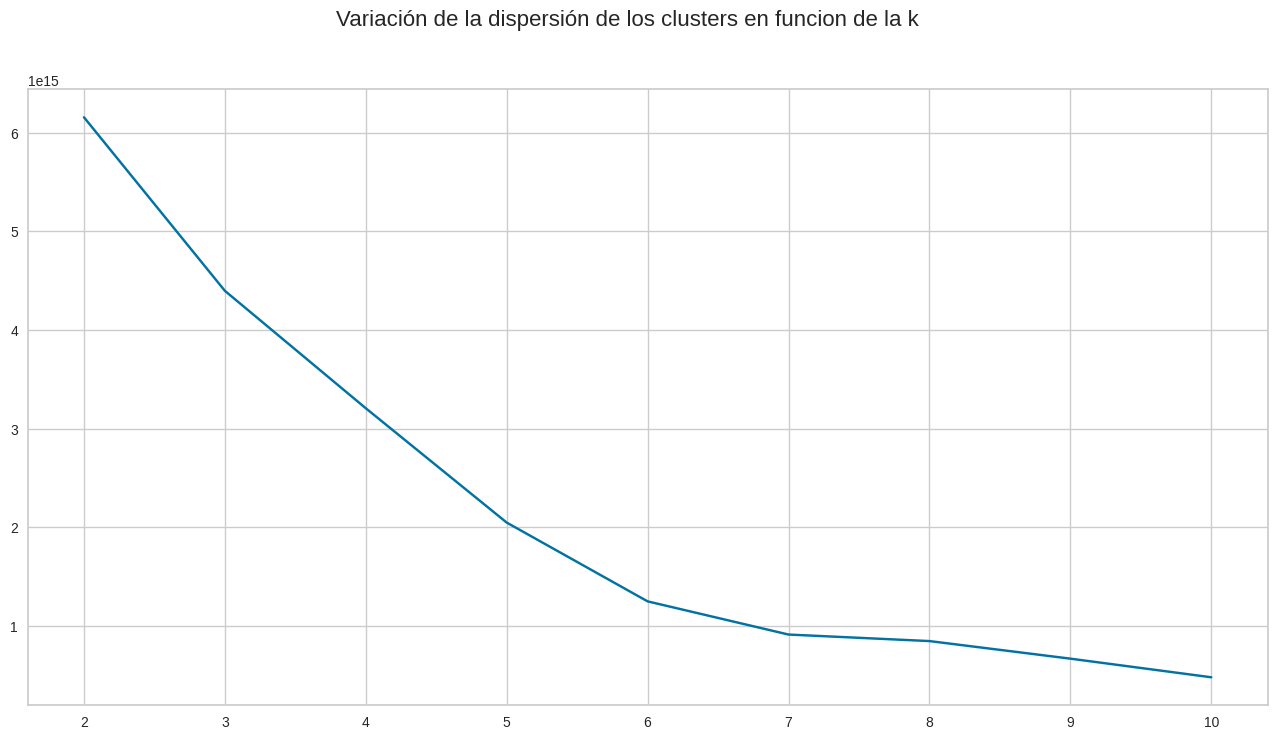

In [34]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values=list(sse.keys())
y_values=list(sse.values())

ax.plot(x_values, y_values, label= "Inertia/dispersion de los clusters")
fig.suptitle("Variación de la dispersión de los clusters en funcion de la k", fontsize=16);

In [35]:
# Usamos un 6 cluster ya que es donde se produce el mayor cambio de pendiente en la elbow_curve
pipe = Pipeline(steps=[
    ('RobustScaler', RobustScaler(quantile_range = (0, 99.0))),
    ('Clustering', KMeans(n_clusters=6, random_state=123))
])
pipe.fit(df_final)

Pipeline(steps=[('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=6, random_state=123))])

In [36]:
labels = pipe['Clustering'].labels_
set(labels)

{np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)}

In [37]:
df_final_clustered = df_final.copy()
df_final_clustered['cluster'] = labels

df_final_clustered.head()

,months_in_company,gender,age,salary,n_orders,margin_gained,active_customer,total_items,channel_KAT,channel_KFC,channel_KHE,channel_KHK,channel_KHM,channel_KHN,channel_KHQ,channel_OTHERS,cluster
pk_cid,,,,,,,,,,,,,,,,,
15891,2,0,59,176628.78,1,66.4,0.0,0,1,0,0,0,0,0,0,0,0
16063,7,0,62,163192.43,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0
16203,6,1,70,152281.83,1,96.7,1.0,1,1,0,0,0,0,0,0,0,2
16502,9,0,58,176423.12,2,132.9,1.0,2,0,0,0,0,0,1,0,0,4
17457,17,0,54,102405.75,1,56.0,1.0,3,1,0,0,0,0,0,0,0,4


In [38]:
df_final_clustered.to_csv(path.join(base_path, 'df_clustered.csv'))

## 5. Interpretación y Visualización de Clusters

In [39]:
ficha_df = pd.DataFrame()
for i, col in enumerate(df_final.columns):
    resumen_data = df_final_clustered[[col, 'cluster']].groupby('cluster').describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [40]:
# generamos nuestro multiindex
out_index = [
    "Fidelización",
    "Fidelización",
    "Fidelización",

    "Monetario",
    "Monetario",
    "Monetario",

    "Demográfico",
    "Demográfico",
    "Demográfico",

    "Canales",
    "Canales",
    "Canales",
    "Canales",
    "Canales",
    "Canales",
    "Canales",
    "Canales",
    "Canales"
]

inner_index = [
    # Comportamiento y Fidelización
    'months_in_company',
    'active_customer',
    'total_items',
    # Monetarias
    'salary',
    'n_orders',
    'margin_gained',
    # Demográficas
    'gender',
    'age',
    # Adquisición y Canales
    'channel_KWC',
    'channel_KFC',
    'channel_KXE',
    'channel_KXI',
    'channel_KNN',
    'channel_KEW',
    'channel_KHE',
    'channel_OTHERS'
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
      new_multi_index.append((oi, ii, es))

In [41]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [42]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [43]:
tamaño_clusters = df_final_clustered.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [44]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

In [45]:
float_format = '{:.2f}'

In [46]:
(
    ficha_df
    .rename(
        columns = {
            0: "Clientes activos y diversificados",     # Clientes activos, con más variedad de productos que la mayoría, y con una rentabilidad moderada. Suelen ser captados por canales KWC, KXI, KNN, KEW y OTHERS.
            1: "Clientes nuevos de bajo valor",         # Clientes muy inactivos y no rentables. Suelen ser mujeres y su edad media es la más alta. Fueron captados casi exclusivamente por el canal KXE.
            2: "Clientes Leales y de Alto Valor",       # Son los clientes más rentables y activos. Suelen ser mujeres y con una edad media alta. Fueron captados por los canales KHE y KWC.
            3: "Clientes Potenciales de Alto Valor",    # Clientes con alto valor monetario y muchos productos, pero con una frecuencia de compra baja. Suelen ser hombres y con una edad media alta. Fueron captados por el canal KFC.
            4: "Clientes Pasivos pero de Alto Margen",  # Clientes inactivos pero muy rentables. Suelen ser hombres y con una edad media muy alta. Fueron captados por los canales KXE, KWC y KNN.
            5: "Clientes Inactivos y No Rentables"      # Clientes totalmente pasivos, de bajo valor y con pocos productos. Suelen ser hombres y con una edad media media. Fueron captados por los canales KXE y KHE.
        },
    )
    .style
    .format(float_format)
    .background_gradient(cmap = 'Blues', axis = 1)
)

## 6. Resultados

### Descripción de los clusteres:

La división en 6 clústeres ha resultado ser muy buena para un plan de marketing a futuro. Cada clúster tiene un perfil claro y diferenciado, lo que permitirá crear estrategias específicas para cada grupo:

* Clúster 0: **Clientes Activos y Diversificados** (43,915 clientes)
Este es un grupo con una antigüedad media y una buena variedad de productos (total_items media de 38). La mayoría de estos clientes están activos (active_customer media de 0.56) y son rentables (margin_gained media de 150), aunque con una alta desviación, lo que indica que hay clientes de alto y bajo margen.
  * Plan de accion: Se podría ofrecer productos complementarios o programas de fidelización para mantener su compromiso.

* Clúster 1: **Clientes Nuevos de Bajo Valor** (89,116 clientes.)
Descripción: El grupo con el menor número de pedidos (n_orders media de 0.13) y la menor rentabilidad (margin_gained media de 128) de todos los clústeres. Son clientes con una antigüedad media, pero su actividad es casi nula.
  * Plan de accion: Necesitan campañas de onboarding o promociones específicas para animarlos a realizar su primera compra.

* Clúster 2: **Clientes Leales y de Alto Valor** (83,691 clientes)
Descripción: Este es el grupo con el mayor número de pedidos (n_orders media de 1.23) y el mayor margen de ganancia (margin_gained media de 575), lo que los convierte en los clientes más valiosos. Tienen una antigüedad media y una buena cantidad de productos.
  * Plan de accion: Son los clientes más valiosos. Hay que mimarlos y protegerlos de la competencia con un servicio exclusivo o programas de premium.

* Clúster 3: **Clientes Potenciales de Alto Valor** (59,922 clientes)
Descripción: Grupo con una antigüedad media, un alto número de productos (total_items media de 39.96) y un buen margen de ganancia (margin_gained media de 485). A diferencia del Clúster 2, sus pedidos (n_orders media de 0.47) no son tan frecuentes.
  * Plan de accion: Son clientes que tienen productos y pueden comprar más. El objetivo es incentivarlos con ofertas personalizadas para aumentar su frecuencia de compra.

* Clúster 4: **Clientes Pasivos pero de Alto Margen** (57,519 clientes)
Descripción: A pesar de que tienen una antigüedad media, su nivel de actividad es casi nulo (active_customer media de 0). Sin embargo, son un grupo con un alto margen de ganancia (margin_gained media de 834), aunque con pocos pedidos. Tienen un número medio de productos.
  * Plan de accion: Aunque no son activos, generan buenos ingresos. Se les podría incentivar a reactivarse con campañas de productos de alto valor.

* Clúster 5: **Clientes Inactivos y No Rentables** (122,009 clientes)
Descripción: Este es el grupo más grande y con la menor rentabilidad (margin_gained media de 22.88). Los clientes en este clúster tienen una antigüedad media, pero su actividad (active_customer media de 0) y su frecuencia de compra (n_orders media de 0.18) son muy bajas.
  * Plan de accion: Este es el grupo de clientes con menos valor. Se les podría enviar una campaña genérica de reactivación, y si no responden, la empresa podría considerar reducir los costes de marketing dirigidos a este grupo.